In [101]:
import sqlite3
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy.stats import rankdata
from sklearn.preprocessing import MinMaxScaler

In [58]:
connection=sqlite3.connect("shots_dataset_ludo_exercise.sqlite")

In [59]:
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", connection)
print(tables)


            name
0  shots_dataset


In [60]:
shots = pd.read_sql("SELECT * FROM shots_dataset",connection)

In [5]:
connection.close()

In [61]:
print(shots.head())

   player_id                   player_name player_birth_date  team_id  \
0     5678.0  Jefferson Andrés Lerma Solís        1994-10-25      221   
1     6742.0        Sergio Gontán Gallardo        1991-12-28      322   
2     6557.0       Adrián González Morales        1988-05-25      322   
3     6566.0          Borja González Tomás        1992-08-25      322   
4    27250.0                  Nabil Ghilas        1990-04-20      221   

    team_name      x     y shot_context   play_context   body_part  \
0  Levante UD  112.5  42.1    Open Play    From Corner        Head   
1       Eibar   90.9  39.9    Open Play    From Corner  Right Foot   
2       Eibar  103.1  52.5    Open Play  From Throw In  Right Foot   
3       Eibar  116.6  38.6    Open Play    From Corner        Head   
4  Levante UD  112.4  35.8    Open Play  From Throw In        Head   

     technique     outcome  
0       Normal  Off Target  
1       Normal       Saved  
2  Half Volley     Blocked  
3       Normal        Go

In [62]:
### LOOKING AT CLASS BALANCE WITHIN THE DATA SET ####

print(shots.shape)
print(shots['play_context'].value_counts())
print(shots['shot_context'].value_counts())
print(shots['technique'].value_counts())

(45719, 12)
play_context
Regular Play      14991
From Free Kick     9643
From Throw In      8098
From Corner        7395
From Counter       2043
From Goal Kick     1727
From Keeper         778
Other               540
From Kick Off       504
Name: count, dtype: int64
shot_context
Open Play    43096
Free Kick     2124
Penalty        486
Corner          13
Name: count, dtype: int64
technique
Normal           34689
Half Volley       6854
Volley            3156
Lob                404
Overhead Kick      259
Backheel           183
Diving Header      174
Name: count, dtype: int64


In [63]:
#### FILTERING OUT OPEN PLAY DATA ####
shots=shots[shots["shot_context"]=="Open Play"]

In [64]:
shots.head()

,player_id,player_name,player_birth_date,team_id,team_name,x,y,shot_context,play_context,body_part,technique,outcome
0,5678.0,Jefferson Andrés Lerma Solís,1994-10-25,221,Levante UD,112.5,42.1,Open Play,From Corner,Head,Normal,Off Target
1,6742.0,Sergio Gontán Gallardo,1991-12-28,322,Eibar,90.9,39.9,Open Play,From Corner,Right Foot,Normal,Saved
2,6557.0,Adrián González Morales,1988-05-25,322,Eibar,103.1,52.5,Open Play,From Throw In,Right Foot,Half Volley,Blocked
3,6566.0,Borja González Tomás,1992-08-25,322,Eibar,116.6,38.6,Open Play,From Corner,Head,Normal,Goal
4,27250.0,Nabil Ghilas,1990-04-20,221,Levante UD,112.4,35.8,Open Play,From Throw In,Head,Normal,Off Target


In [131]:
###### FEATURE ENGINEERING ######

# Pitch = 120x80, goal centre at (120,40)
goal_x, goal_y = 120, 40
goal_width = 8

# Distance to centre of goal 
shots["distance"] = np.sqrt((goal_x - shots["x"])**2 + (goal_y - shots["y"])**2)


def calculate_angle(row):
    g0 = np.array([120, 44])   # top post
    g1 = np.array([120, 36])   # bottom post
    p  = np.array([row["x"], row["y"]])   # shot location
    
    v0 = g0 - p
    v1 = g1 - p
    
    angle = np.arctan2(np.linalg.det([v0, v1]), np.dot(v0, v1))
    return abs(np.degrees(angle))

# Apply to each row
shots["angle"] = shots.apply(calculate_angle, axis=1)

# Body part
shots["header"] = (shots["body_part"] == "Head").astype(int)

# Technique 
shots["technique_int"]=(shots["technique"]=="Normal").astype(int)

# Play context
shots["play_context_int"]=(shots["play_context"]=="Regular Play").astype(int)


# Target label
shots["goal"] = (shots["outcome"] == "Goal").astype(int)

scaler = MinMaxScaler()

# Select continuous features to scale
features_to_scale = ["distance", "angle"]

shots[["distance_scaled", "angle_scaled"]] = scaler.fit_transform(shots[features_to_scale])



                                    Model  Pseudo R²  Accuracy  ROC AUC
0                       Model 1: distance      0.116     0.903    0.753
1               Model 2: distance + angle      0.124     0.906    0.757
2  Model 3: distance + angle + dist*angle      0.124     0.905    0.757
3               Model 4: Model 3 + header      0.158     0.904    0.792
4        Model 5: Model 4 + technique_int      0.164     0.906    0.793
5     Model 6: Model 5 + play_context_int      0.165     0.906    0.793


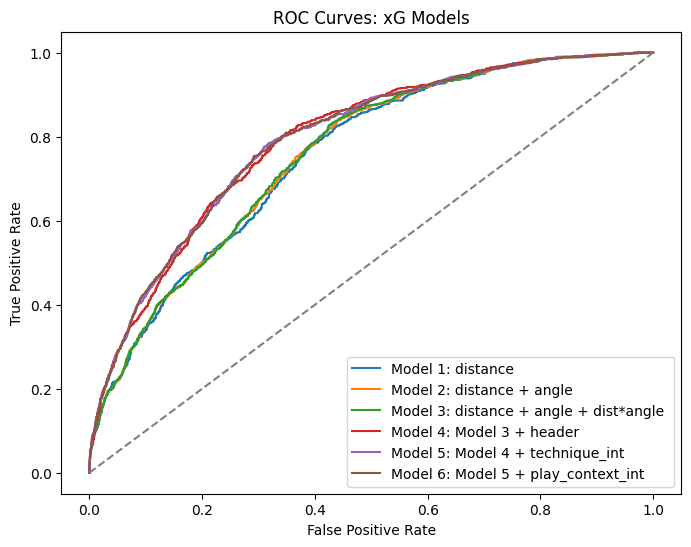

In [133]:

# Interaction term
shots["dist_angle"] = shots["distance"] * shots["angle"]

# Train/test split
train, test = train_test_split(shots, test_size=0.2, random_state=2)

# Store results
results = []
roc_curves = {}

# Define model specs
models = {
    "Model 1: distance": ["distance"],
    "Model 2: distance + angle": ["distance", "angle"],
    "Model 3: distance + angle + dist*angle": ["distance", "angle", "dist_angle"],
    "Model 4: Model 3 + header": ["distance", "angle", "dist_angle", "header"],
    "Model 5: Model 4 + technique_int": ["distance", "angle", "dist_angle", "header", "technique_int"],
    "Model 6: Model 5 + play_context_int": ["distance", "angle", "dist_angle", "header", "technique_int", "play_context_int"]

}

for name, predictors in models.items():
    # ---------------------------
    # Fit model on training data
    # ---------------------------
    X_train = sm.add_constant(train[predictors])
    y_train = train["goal"]
    model = sm.Logit(y_train, X_train).fit(disp=False)

    # ---------------------------
    # Predict on test set
    # ---------------------------
    X_test = sm.add_constant(test[predictors])
    y_test = test["goal"]
    y_pred_prob = model.predict(X_test)
    y_pred_class = (y_pred_prob > 0.5).astype(int)

    # ---------------------------
    # Metrics
    # ---------------------------
    pseudo_r2 = model.prsquared
    accuracy = accuracy_score(y_test, y_pred_class)
    auc = roc_auc_score(y_test, y_pred_prob)

    results.append({
        "Model": name,
        "Pseudo R²": round(pseudo_r2, 3),
        "Accuracy": round(accuracy, 3),
        "ROC AUC": round(auc, 3)
    })

    # Store ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_curves[name] = (fpr, tpr, auc,accuracy)

# Results table
results_df = pd.DataFrame(results)
print(results_df)

# --------------------------------------------------
# Plot ROC curves
# --------------------------------------------------
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc, accuracy) in roc_curves.items():
    plt.plot(
        fpr, 
        tpr,
        label=f"{name} "
        #(AUC = {auc:.3f}, Acc = {accuracy:.3f})"
    )

# Diagonal line
plt.plot([0,1],[0,1], linestyle="--", color="grey")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: xG Models")
plt.legend(loc="lower right")
plt.show()




In [104]:
# Define features and target
features = ["distance","angle","header","technique_int"]
X = shots[features]
y = shots["goal"]

# Add intercept (constant term)
X = sm.add_constant(X)

# Fit logistic regression with statsmodels
model = sm.Logit(y, X).fit()

# Show summary with coefficients, p-values, confidence intervals
print(model.summary())

# Add xG predictions
shots["xG"] = model.predict(X)


Optimization terminated successfully.
         Current function value: 0.267571
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                43096
Model:                          Logit   Df Residuals:                    43091
Method:                           MLE   Df Model:                            4
Date:                Mon, 25 Aug 2025   Pseudo R-squ.:                  0.1632
Time:                        20:39:01   Log-Likelihood:                -11531.
converged:                       True   LL-Null:                       -13781.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0870      0.111     -9.757      0.000      -1.305      -0.869
distance         -0.

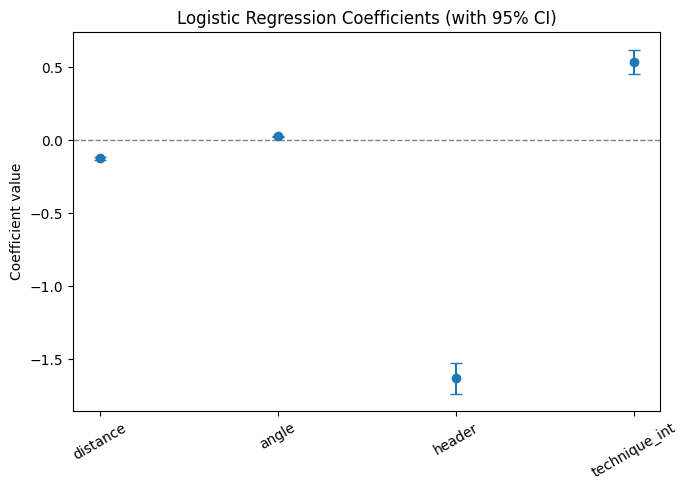

In [105]:
# Get coefficients and 95% confidence intervals
params = model.params
conf = model.conf_int()
conf["coef"] = params
conf.columns = ["lower", "upper", "coef"]

# Drop intercept if you only want features
conf = conf.drop("const")

# Plot
plt.figure(figsize=(7,5))
plt.errorbar(conf.index, conf["coef"], 
             yerr=[conf["coef"]-conf["lower"], conf["upper"]-conf["coef"]], 
             fmt="o", capsize=4)

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.title("Logistic Regression Coefficients (with 95% CI)")
plt.ylabel("Coefficient value")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

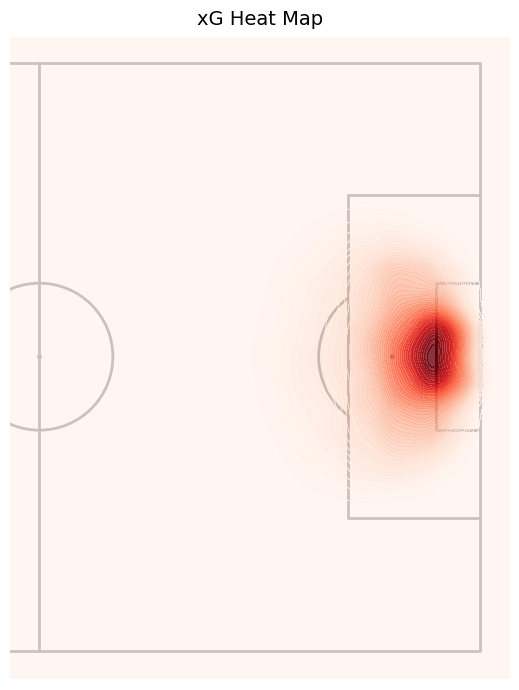

In [115]:
pitch = Pitch(pitch_type='statsbomb', half=True, pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10,7))

# KDE heatmap weighted by xG
sns.kdeplot(
    x=shots['x'], 
    y=shots['y'],
    weights=shots['xG'],   # weight by model xG
    fill=True,
    thresh=0,
    levels=50,
    cmap='Reds',
    alpha=0.8,
    ax=ax
)

ax.set_title("xG Heat Map", fontsize=14)
plt.show()

In [134]:
bins = [0, 5, 10, 15, 20, 30, 40, 60]  # adjust to your pitch scale
labels = ["0-5m", "5-10m", "10-15m", "15-20m", "20-30m", "30-40m", "40m+"]

shots["distance_bin"] = pd.cut(shots["distance"], bins=bins, labels=labels, right=False)


In [135]:
summary = (
    shots.groupby("distance_bin")
    .agg(
        shots=("xG", "count"),
        goals=("goal", "sum"),
        avg_xG=("xG", "mean")
    )
    .reset_index()
)

summary["actual_rate"] = summary["goals"] / summary["shots"]
summary["difference"] = summary["avg_xG"] - summary["actual_rate"]


/var/folders/41/q_56pzxj62b91jxq8xsy_scc0000gn/T/ipykernel_68539/2038924573.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



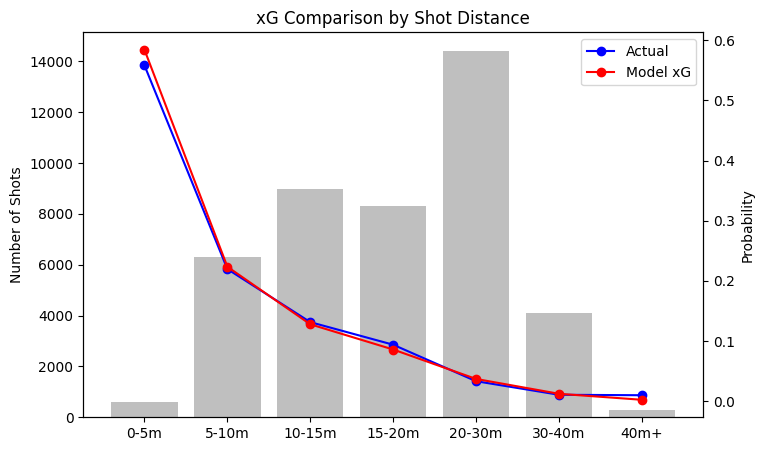

In [136]:
fig, ax1 = plt.subplots(figsize=(8,5))

# Shots bar
ax1.bar(summary["distance_bin"], summary["shots"], alpha=0.5, color="grey")
ax1.set_ylabel("Number of Shots")

# Overlay actual vs xG rates
ax2 = ax1.twinx()
ax2.plot(summary["distance_bin"], summary["actual_rate"], marker="o", label="Actual", color="blue")
ax2.plot(summary["distance_bin"], summary["avg_xG"], marker="o", label="Model xG", color="red")
ax2.set_ylabel("Probability")

ax1.set_title("xG Comparison by Shot Distance")
ax2.legend(loc="upper right")

plt.show()


In [77]:
# Define the function
def age_in_1516(birthdate):
    today = date.today()
    return 2015 - birthdate.year - ((1, 1) < (birthdate.month, birthdate.day))

# Ensure birthdate is datetime type
shots["player_birth_date"] = pd.to_datetime(shots["player_birth_date"], errors="coerce")

# Apply function to create new column
shots["age"] = shots["player_birth_date"].apply(age_in_1516)


In [78]:
shots[['player_birth_date','age']]
print(shots["age"].describe())


count    41326.000000
mean        24.724556
std          3.591499
min         15.000000
25%         22.000000
50%         25.000000
75%         27.000000
max         39.000000
Name: age, dtype: float64


In [137]:
young_players=shots[shots['age']<=23]
young_players.head()

,player_id,player_name,player_birth_date,team_id,team_name,x,y,shot_context,play_context,body_part,...,Other,Regular Play,goal,play_context_int,dist_angle,xG,distance_bin,age,distance_scaled,angle_scaled
0,5678.0,Jefferson Andrés Lerma Solís,1994-10-25,221,Levante UD,112.5,42.1,Open Play,From Corner,Head,...,0,0,0,0,415.424095,0.142851,5-10m,20.0,0.081133,0.296325
1,6742.0,Sergio Gontán Gallardo,1991-12-28,322,Eibar,90.9,39.9,Open Play,From Corner,Right Foot,...,0,0,0,0,455.509146,0.022178,20-30m,23.0,0.322761,0.086962
3,6566.0,Borja González Tomás,1992-08-25,322,Eibar,116.6,38.6,Open Play,From Corner,Head,...,0,0,1,0,350.081523,0.448384,0-5m,22.0,0.034518,0.528942
11,6566.0,Borja González Tomás,1992-08-25,322,Eibar,113.0,34.4,Open Play,From Counter,Right Foot,...,0,0,1,0,367.778810,0.239096,5-10m,22.0,0.094465,0.227926
18,6699.0,Ander Capa Rodríguez,1992-02-08,322,Eibar,103.2,35.7,Open Play,From Corner,Right Foot,...,0,0,0,0,438.196030,0.068671,15-20m,22.0,0.189444,0.140381


In [138]:
player_summary = (
    young_players.groupby(["player_name","age"])
    .agg(
        shots_taken = ("goal", "count"),     # number of shots
        goals = ("goal", "sum"),             # number of goals
        total_xG = ("xG", "sum"),            # sum of xG
        avg_xG = ("xG", "mean"),              # average xG per shot
        teams=("team_name",lambda x: list(set(x)))    )
    .reset_index()
    .sort_values("avg_xG", ascending=False)
)

print(player_summary.head())

             player_name   age  shots_taken  goals  total_xG    avg_xG  \
746       Soualiho Meïté  20.0            1      0  0.505600  0.505600   
782        Tyler Roberts  15.0            1      0  0.489271  0.489271   
688  Roberto Suárez Pier  19.0            1      0  0.388233  0.388233   
834     Łukasz Skorupski  23.0            1      0  0.355492  0.355492   
323        Jack Wilshere  23.0            1      0  0.347858  0.347858   

                        teams  
746                   [Lille]  
782    [West Bromwich Albion]  
688  [RC Deportivo La Coruña]  
834                  [Empoli]  
323                 [Arsenal]  


(array([505., 157.,  83.,  57.,  16.,   9.,   3.,   3.,   2.,   1.]),
 array([  1. ,  16.1,  31.2,  46.3,  61.4,  76.5,  91.6, 106.7, 121.8,
        136.9, 152. ]),
 <BarContainer object of 10 artists>)

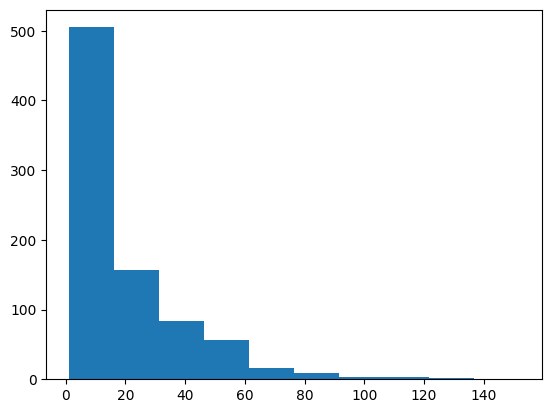

In [83]:
plt.hist(player_summary['shots_taken'])

In [84]:
## filter out players who took less than 20 shots - otherwise get noisy data

player_summary=player_summary[player_summary['shots_taken']>=20]

In [86]:
player_summary['overperformance']=(player_summary['goals']-player_summary['total_xG'])/player_summary['shots_taken']

/var/folders/41/q_56pzxj62b91jxq8xsy_scc0000gn/T/ipykernel_68539/1906977491.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
player_summary.sort_values(by='total_xG',ascending=False).head(n=50)

,player_name,age,shots_taken,goals,total_xG,avg_xG,teams,overperformance
701,Romelu Lukaku Menama,21.0,109,17,17.376951,0.159422,[Everton],-0.003458
297,Harry Kane,21.0,152,20,16.780940,0.110401,[Tottenham Hotspur],0.021178
600,Neymar da Silva Santos Junior,22.0,102,18,16.531256,0.162071,[Barcelona],0.014399
568,Michy Batshuayi Tunga,21.0,115,15,15.920925,0.138443,[Marseille],-0.008008
49,Alexandre Lacazette,23.0,91,19,14.530583,0.159677,[Lyon],0.049114
113,Borja González Tomás,22.0,91,15,14.099628,0.154941,[Eibar],0.009894
527,Martin Braithwaite Christensen,23.0,99,8,13.191057,0.133243,[Toulouse],-0.052435
81,Antoine Griezmann,23.0,85,19,11.401254,0.134132,[Atlético Madrid],0.089397
713,Sadio Mané,22.0,85,11,10.770893,0.126716,[Southampton],0.002695
30,Aleksandar Mitrović,20.0,78,7,10.206592,0.130854,[Newcastle United],-0.041110


In [117]:
import plotly.express as px

df = player_summary.copy()

# Select top 6 players by total_xG
#top_xg_df = df.sort_values("total_xG", ascending=False).head(6)

# Scatter plot for top 6 only
fig = px.scatter(
    df,
    x="total_xG",
    y="goals",
    size_max=15,
    hover_data=["player_name", "teams","age","goals", "total_xG"]
)

# Add diagonal reference line (Goals = xG)
lims = [df[["total_xG","goals"]].min().min(), df[["total_xG","goals"]].max().max()]
fig.add_shape(
    type="line",
    x0=lims[0], y0=lims[0],
    x1=lims[1], y1=lims[1],
    line=dict(color="black", dash="dash")
)

fig.update_layout(
    title="Goals vs Expected Goals (xG)",
    xaxis_title="Total Expected Goals (xG)",
    yaxis_title="Goals Scored",
    legend_title="Player",
    width=900,
    height=600
)

fig.show()


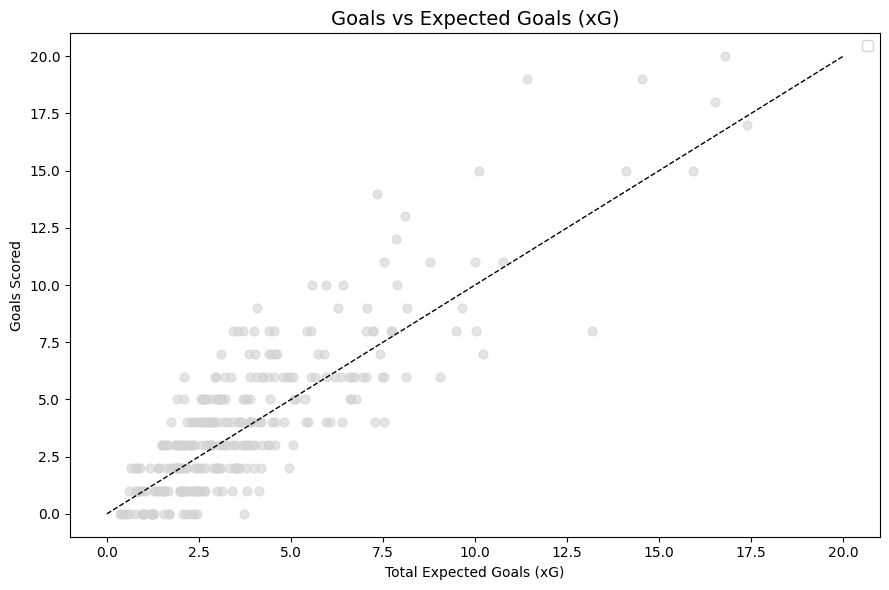

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))

# Base scatter: all players (grey)
plt.scatter(
    player_summary["total_xG"], 
    player_summary["goals"], 
    color="lightgrey", alpha=0.6, s=40
)

# Diagonal line (Goals = xG)
lims = [player_summary[["total_xG","goals"]].min().min(), 
        player_summary[["total_xG","goals"]].max().max()]
plt.plot(lims, lims, "k--", lw=1)

plt.title("Goals vs Expected Goals (xG)", fontsize=14)
plt.xlabel("Total Expected Goals (xG)")
plt.ylabel("Goals Scored")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df = player_summary.copy()

# Calculate percentiles for goals and xG
df["goals_percentile"] = df["goals"].rank(pct=True) * 100
df["xg_percentile"] = df["total_xG"].rank(pct=True) * 100

# Combine with equal weights
df["shooting_score"] = 0.5 * df["goals_percentile"] + 0.5 * df["xg_percentile"]

# Sort by score
df = df.sort_values("shooting_score", ascending=False)

# Display top 10
print(df[["player_name", "goals", "total_xG", "shooting_score"]].head(10))


                       player_name  goals   total_xG  shooting_score
297                     Harry Kane     20  16.780940       99.831081
701           Romelu Lukaku Menama     17  17.376951       99.324324
600  Neymar da Silva Santos Junior     18  16.531256       99.155405
49             Alexandre Lacazette     19  14.530583       99.070946
81               Antoine Griezmann     19  11.401254       98.564189
568          Michy Batshuayi Tunga     15  15.920925       98.479730
113           Borja González Tomás     15  14.099628       98.141892
554    Mauro Emanuel Icardi Rivero     15  10.119717       97.297297
713                     Sadio Mané     11  10.770893       96.537162
251       Francisco Alcácer García     11   9.994244       95.861486
